In [7]:
# -----------------------------
# 8) Save Trained Model & Scaler
# -----------------------------
import pickle

# Save both model and scaler together
with open("fraud_detection_model.pkl", "wb") as f:
    pickle.dump({"model": clf, "scaler": scaler, "features": X_train_scaled.columns.tolist()}, f)

print("Model saved as fraud_detection_model.pkl")

# -----------------------------
# 9) Load & Test Saved Model
# -----------------------------
with open("fraud_detection_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)

loaded_model = saved_objects["model"]
loaded_scaler = saved_objects["scaler"]
loaded_features = saved_objects["features"]

print("Model and scaler loaded successfully.")

# Example: make predictions on a few validation rows
sample = X_valid.iloc[:5].copy()
sample_scaled = sample.copy()
sample_scaled[num_cols_train] = loaded_scaler.transform(sample[num_cols_train])
pred_probs = loaded_model.predict_proba(sample_scaled)[:, 1]

print("\nSample Predictions (fraud probability):")
print(pred_probs)


Model saved as fraud_detection_model.pkl
Model and scaler loaded successfully.

Sample Predictions (fraud probability):
[1.43466323e-15 7.31707295e-06 9.99999868e-01 9.81650484e-01
 5.73236435e-20]



--- Missing Values (%) ---
step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

--- Model Performance ---
ROC-AUC: 0.906159
PR-AUC : 0.007052
Best threshold (by F1): 0.999998

Confusion Matrix:
 [[18032  1945]
 [    7    16]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9026    0.9487     19977
           1     0.0082    0.6957    0.0161        23

    accuracy                         0.9024     20000
   macro avg     0.5039    0.7991    0.4824     20000
weighted avg     0.9985    0.9024    0.9476     20000



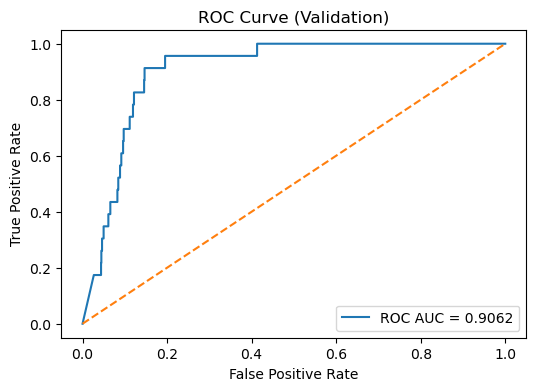

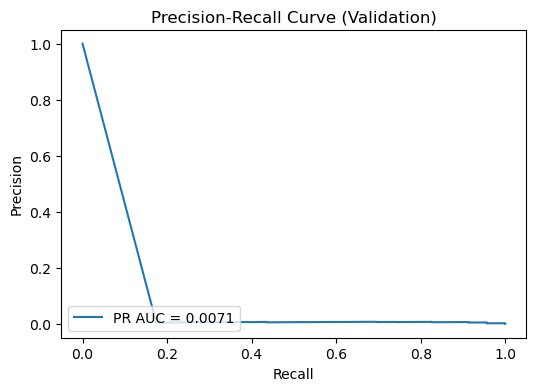

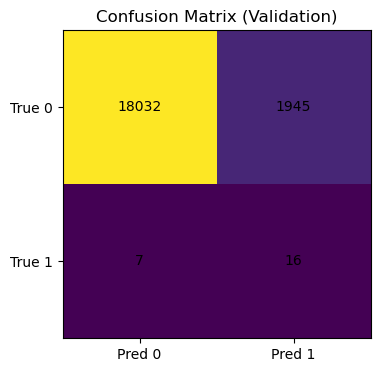


--- Top Positive Coefficients (fraud-indicative) ---
           feature       coef
14   type_TRANSFER  25.925774
11   type_CASH_OUT  23.409177
7        errorOrig  13.732253
5   newbalanceDest  12.558838
8        deltaDest   8.553764
1           amount   6.653212
6        deltaOrig   5.999003
9        errorDest  -2.111401
12      type_DEBIT  -3.706967
0             step  -5.125344
10    type_CASH_IN  -6.367468
13    type_PAYMENT -11.825333
4   oldbalanceDest -12.293637
2    oldbalanceOrg -14.452369
3   newbalanceOrig -25.929757

--- Top Negative Coefficients (genuine-indicative) ---
           feature       coef
14   type_TRANSFER  25.925774
11   type_CASH_OUT  23.409177
7        errorOrig  13.732253
5   newbalanceDest  12.558838
8        deltaDest   8.553764
1           amount   6.653212
6        deltaOrig   5.999003
9        errorDest  -2.111401
12      type_DEBIT  -3.706967
0             step  -5.125344
10    type_CASH_IN  -6.367468
13    type_PAYMENT -11.825333
4   oldbalanceDest -

In [5]:
# -----------------------------
# Fraud Detection End-to-End Notebook
# -----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
from textwrap import dedent

# -----------------------------
# Load Data
# -----------------------------
CSV_PATH = r"C:\Users\user\Downloads\Fraud.csv"  # <-- update path if needed
N_ROWS = 100_000   # for quick demo; use None to load full dataset
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Infer dtypes quickly
peek = pd.read_csv(CSV_PATH, nrows=5000)
dtype_map = {}
for col in peek.columns:
    if col in ["type", "nameOrig", "nameDest"]:
        dtype_map[col] = "category"
    elif col in ["isFraud", "isFlaggedFraud"]:
        dtype_map[col] = "int8"
    elif col == "step":
        dtype_map[col] = "int32"
    else:
        dtype_map[col] = "float32"

df = pd.read_csv(CSV_PATH, nrows=N_ROWS, dtype=dtype_map)
df.columns = [c.strip() for c in df.columns]
target_col = "isFraud"

# -----------------------------
# 1) Data Cleaning
# -----------------------------
print("\n--- Missing Values (%) ---")
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print(missing_pct)

# Create indicators for missing balances
for col in ["oldbalanceDest", "newbalanceDest"]:
    if col in df.columns:
        df[f"{col}_was_missing"] = df[col].isna().astype("int8")

# Impute numeric NaNs with 0
num_cols = df.select_dtypes(include=["float32", "float64", "int32", "int64", "int8"]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["isFraud", "isFlaggedFraud"] and c != target_col]
if len(num_cols) > 0:
    imp = SimpleImputer(strategy="constant", fill_value=0.0)
    df[num_cols] = imp.fit_transform(df[num_cols])

# -----------------------------
# 2) Feature Engineering
# -----------------------------
def safe_diff(a, b): return (a - b).astype("float32")

if set(["oldbalanceOrg", "newbalanceOrig", "amount"]).issubset(df.columns):
    df["deltaOrig"] = safe_diff(df["oldbalanceOrg"], df["newbalanceOrig"])
    df["errorOrig"] = safe_diff(df["oldbalanceOrg"] - df["amount"], df["newbalanceOrig"])

if set(["oldbalanceDest", "newbalanceDest", "amount"]).issubset(df.columns):
    df["deltaDest"] = safe_diff(df["newbalanceDest"], df["oldbalanceDest"])
    df["errorDest"] = safe_diff(df["oldbalanceDest"] + df["amount"], df["newbalanceDest"])

# One-hot encode type
if "type" in df.columns:
    df = pd.concat([df.drop(columns=["type"]), pd.get_dummies(df["type"], prefix="type")], axis=1)

# Drop high-cardinality IDs
for id_col in ["nameOrig", "nameDest"]:
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

# Winsorization (clip outliers)
for col in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest",
            "deltaOrig", "deltaDest", "errorOrig", "errorDest"]:
    if col in df.columns:
        q = df[col].quantile([0.005, 0.995]).values
        if len(q) == 2:
            df[col] = df[col].clip(lower=q[0], upper=q[1])

# -----------------------------
# 3) Variable Selection
# -----------------------------
X = df.drop(columns=[target_col, "isFlaggedFraud"], errors="ignore")
y = df[target_col].astype(int)

# Drop constant columns
const_cols = X.columns[X.nunique() <= 1]
X = X.drop(columns=const_cols)

# -----------------------------
# Train / Validation Split
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale numeric features
num_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_train_scaled[num_cols_train] = scaler.fit_transform(X_train[num_cols_train])
X_valid_scaled[num_cols_train] = scaler.transform(X_valid[num_cols_train])

# -----------------------------
# 4) Model Training
# -----------------------------
clf = SGDClassifier(
    loss="log_loss",
    class_weight="balanced",
    max_iter=2000,
    tol=1e-4,
    random_state=RANDOM_STATE,
    alpha=1e-4
)
clf.fit(X_train_scaled, y_train)

# -----------------------------
# 5) Performance Evaluation
# -----------------------------
valid_proba = clf.predict_proba(X_valid_scaled)[:, 1]
roc_auc = roc_auc_score(y_valid, valid_proba)
pr_auc = average_precision_score(y_valid, valid_proba)

prec, rec, thr = precision_recall_curve(y_valid, valid_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
y_pred = (valid_proba >= best_thr).astype(int)

cm = confusion_matrix(y_valid, y_pred)
report = classification_report(y_valid, y_pred, digits=4)

print("\n--- Model Performance ---")
print("ROC-AUC:", round(roc_auc, 6))
print("PR-AUC :", round(pr_auc, 6))
print("Best threshold (by F1):", round(float(best_thr), 6))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# -----------------------------
# Plots
# -----------------------------
fpr, tpr, _ = roc_curve(y_valid, valid_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")
plt.show()

# -----------------------------
# 6) Key Predictors
# -----------------------------
coef_df = pd.DataFrame({"feature": X_train_scaled.columns, "coef": clf.coef_[0]}).sort_values("coef", ascending=False)

print("\n--- Top Positive Coefficients (fraud-indicative) ---")
print(coef_df.head(15))
print("\n--- Top Negative Coefficients (genuine-indicative) ---")
print(coef_df.tail(15))

# -----------------------------
# 7) Recommendations
# -----------------------------
print(dedent("""
Recommendations:
---------------
• Enforce step-up authentication (OTP/biometrics) for high-risk scores, TRANSFER/CASH_OUT types, and large/unusual amounts.
• Implement payee/device velocity limits and cool-off for new payees.
• Add real-time consistency checks (balance before - amount ≈ balance after).
• Monitor drift on amount, type, and error features; retrain regularly.

Measuring Success:
-----------------
• Compare fraud loss, precision/recall, and analyst workload before vs after rollout.
• Run phased rollout (A/B test) by customer segments.
• Recalibrate threshold from PR curve quarterly.
"""))


In [19]:
def predict_new_transaction(transaction_dict, model_path="fraud_detection_model.pkl"):
    """
    Predict fraud probability for a single new transaction.
    """
    import pickle
    import pandas as pd

    # Load saved model, scaler, and features
    with open(model_path, "rb") as f:
        saved_objects = pickle.load(f)

    model = saved_objects["model"]
    scaler = saved_objects["scaler"]
    features = saved_objects["features"]

    # Convert dict to dataframe
    tx = pd.DataFrame([transaction_dict])

    # One-hot encode 'type'
    if "type" in tx.columns:
        tx = pd.concat([tx.drop(columns=["type"]), pd.get_dummies(tx["type"], prefix="type")], axis=1)

    # --- Ensure all training features exist ---
    tx = tx.reindex(columns=features, fill_value=0)

    # Scale numeric features (only those seen at training)
    num_cols_tx = [col for col in tx.columns if col in scaler.feature_names_in_]
    tx[num_cols_tx] = scaler.transform(tx[num_cols_tx])

    # Predict probability
    prob = model.predict_proba(tx)[:, 1][0]
    return prob


In [21]:
new_tx = {
    "step": 10,
    "type": "TRANSFER",
    "amount": 100000.0,
    "oldbalanceOrg": 200000.0,
    "newbalanceOrig": 100000.0,
    "oldbalanceDest": 0.0,
    "newbalanceDest": 100000.0,
    "isFlaggedFraud": 0
}

probability = predict_new_transaction(new_tx)
print(f"Fraud probability for new transaction: {probability:.4f}")


Fraud probability for new transaction: 0.8035


In [13]:
# -----------------------------
# 8) Save Trained Model & Scaler
# -----------------------------
import pickle

# Save both model and scaler together
with open("fraud_detection_model.pkl", "wb") as f:
    pickle.dump({"model": clf, "scaler": scaler, "features": X_train_scaled.columns.tolist()}, f)

print("Model saved as fraud_detection_model.pkl")

# -----------------------------
# 9) Load & Test Saved Model
# -----------------------------
with open("fraud_detection_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)

loaded_model = saved_objects["model"]
loaded_scaler = saved_objects["scaler"]
loaded_features = saved_objects["features"]

print("Model and scaler loaded successfully.")

# Example: make predictions on a few validation rows
sample = X_valid.iloc[:5].copy()
sample_scaled = sample.copy()
sample_scaled[num_cols_train] = loaded_scaler.transform(sample[num_cols_train])
pred_probs = loaded_model.predict_proba(sample_scaled)[:, 1]

print("\nSample Predictions (fraud probability):")
print(pred_probs)


Model saved as fraud_detection_model.pkl
Model and scaler loaded successfully.

Sample Predictions (fraud probability):
[1.43466323e-15 7.31707295e-06 9.99999868e-01 9.81650484e-01
 5.73236435e-20]


In [25]:
new_transactions = [
    {
        "step": 5,
        "type": "TRANSFER",
        "amount": 50000.0,
        "oldbalanceOrg": 60000.0,
        "newbalanceOrig": 10000.0,
        "oldbalanceDest": 0.0,
        "newbalanceDest": 50000.0,
        "isFlaggedFraud": 0
    },
    {
        "step": 8,
        "type": "CASH_OUT",
        "amount": 2000.0,
        "oldbalanceOrg": 5000.0,
        "newbalanceOrig": 3000.0,
        "oldbalanceDest": 10000.0,
        "newbalanceDest": 12000.0,
        "isFlaggedFraud": 0
    }
]

batch_result = predict_batch(new_transactions)
print(batch_result)


   fraud_probability
0           1.000000
1           0.983973


In [27]:
# -----------------------------
# Batch Prediction Function
# -----------------------------
def predict_batch(transactions, model_path="fraud_detection_model.pkl"):
    """
    Predict fraud probabilities for a batch of new transactions.
    
    Parameters:
        transactions (list of dicts or DataFrame): list of transaction records
        model_path (str): path to saved pickle file.
    
    Returns:
        DataFrame: fraud probabilities for each transaction
    """
    import pickle
    import pandas as pd

    # Load saved model, scaler, and features
    with open(model_path, "rb") as f:
        saved_objects = pickle.load(f)

    model = saved_objects["model"]
    scaler = saved_objects["scaler"]
    features = saved_objects["features"]

    # Convert to DataFrame
    if isinstance(transactions, list):
        tx_df = pd.DataFrame(transactions)
    else:
        tx_df = transactions.copy()

    # One-hot encode 'type'
    if "type" in tx_df.columns:
        tx_df = pd.concat([tx_df.drop(columns=["type"]), pd.get_dummies(tx_df["type"], prefix="type")], axis=1)

    # Ensure all training features exist
    tx_df = tx_df.reindex(columns=features, fill_value=0)

    # Scale numeric features
    num_cols_tx = [col for col in tx_df.columns if col in scaler.feature_names_in_]
    tx_df[num_cols_tx] = scaler.transform(tx_df[num_cols_tx])

    # Predict probabilities
    probs = model.predict_proba(tx_df)[:, 1]

    # Return as DataFrame
    result = tx_df.copy()
    result["fraud_probability"] = probs
    return result[["fraud_probability"]]
